## Шаг 1. Импорт и подготовка данных  

Загружаем необходимые библиотеки.

In [1]:
#common
import numpy as np
import pandas as pd 
import IPython
from IPython.display import display
import re
import random
import warnings
warnings.simplefilter('ignore')
import calendar

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

#ml
from sklearn.metrics import SCORERS
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.utils import shuffle, resample

#regressors
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb

Загружаем данные.

In [2]:
cars = pd.read_csv('/datasets/autos.csv')

### Первичный анализ данных

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Перед нами задача регрессии.  
Датасет содержит: 354369 наблюдений, 15 признаков и 1 целевой признак.  

Первично обнаруженные проблемы:  
1. Пропущенные значения - требуется обработка.  
2. Вполне вероятно, что дата создания и скачивания объявления, дата последнего визита пользователя, месяц регистрации и почтовый индекс не помогут нам в процессе предсказания цен.  
3. Большая часть признаков - категориальные. Из количественных - пройденный километраж (150 тысяч на машине 1993 года - охотно верится=), мощность двигателя. Так же, наверное, сюда можно отнести год регистрации.  

Копнем глубже.

In [5]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


1. Нет никакой информации о фотографиях. Сообщить тимлиду, отбросить данный столбец.  
2. В нашем датасете достаточно дешевые автомобили - средняя стоимость = 2700 EUR.  
3. Кто-то зарегистрировал автомобиль в 1000м году (сразу после Крещения Руси, там, вероятно, правила постановки на учет обновили), а кто-то подаст документы о регистрации через 8 тысяч лет.  
4. Странный максимальный пробег в 150000 километров - встерчается у подавляющего большинства автомобилей. Сообщить тимлиду, возможно, это особенность сайта - максимальное значение, которое можно выставить = 150000?  
5. Сбита кодировка месяцов регистрации. Если максимальный (последний) месяц - декабрь=12, то месяца 0 быть не должно (или наоборот)  

In [6]:
cars.describe(include=['object', 'bool'])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


Фольксваген гольф седан - самая часто встречающая комплектация (хотя лучше здесь через groupby проверить, седан, возможно из другой модели сюда затесался).  
С типами бензина нужно будет разобраться отдельно.  
В представленном датасете больше машин, которые не находились в ремонте (по крайней мере, по словам их владельцев).  



In [7]:
temp = (
    cars.groupby(['Brand', 'Model', 'VehicleType'])['Power']
    .count().sort_values(ascending=False))

temp.head()

Brand       Model   VehicleType
volkswagen  golf    sedan          14744
opel        corsa   small          10499
volkswagen  polo    small          10267
bmw         3er     sedan           8087
volkswagen  passat  wagon           7134
Name: Power, dtype: int64

Да, действительно, гольф седан - самый частый автомобиль в анкетах продаж.  

Посмотрим на процентные соотношения пропущенных значений.

In [8]:
total = cars.isnull().sum().sort_values(ascending = False)
percent = round(cars.isnull().sum().sort_values(ascending = False)/len(cars)*100,2)

pd.concat([total, percent], axis=1, keys=['Total','Percent']).style.background_gradient(cmap='Reds')

,Total,Percent
NotRepaired,71154,20.08
VehicleType,37490,10.58
FuelType,32895,9.28
Gearbox,19833,5.6
Model,19705,5.56
LastSeen,0,0
PostalCode,0,0
NumberOfPictures,0,0
DateCreated,0,0
Brand,0,0


Была ли машина в ремонте? 20% респондентов не смогли ответить на данный вопрос!   
Предлагаю заполнить эти пропуски значением 'No', предположу, что данные машины не подвергались ремонту и владельцы просто оставили эту строку пустой в анкете (но лучше сказать об этом тимлиду или посоветоваться с коллегами)  
Тип автомобиля попробуем заполнить по марке и модели. Модель - по марке.  
Тип коробки - по году выпуска.  
Тип топлива - возможно, по модели.   

Посмотрим на года регистрации.  
Посчитаем, какой процент годов регистрации выходит за рамки здравого смысла (~1900-2019 годы).

In [9]:
norm_period = (
    cars.query(
    'RegistrationYear > 1900 and RegistrationYear < 2020')['RegistrationYear']
    .sort_values()
    )  

In [10]:
outliers = np.round(100 - (len(norm_period) * 100 / len(cars)), 3)

print('Процент "ненормальных" лет регистрации = ', outliers)

Процент "ненормальных" лет регистрации =  0.048


Меньше 5 сотых процента об общего числа автомобилей имеют неправильно указанный год регистрации, можем спокойно выбросить данные наблюдения.

In [11]:
cars = cars.query('RegistrationYear > 1900 and RegistrationYear < 2020')

---

#### Важный момент!  

Необходимо сообщить о данных выбросах разработчикам сайта - чтобы пофиксили возможноть ввести год, не укладывающийся в "нормальные" сроки (например, с 1910 по настоящее время). Иначе получим выбросы и некорректную работу моделей.

Так же мы имеем примерно 3% записей с нулевой ценой. Предполагаю обратиться к тимлиду и разработчикам - ошибка ли это или нормальные данные. В текущем проекте удалять эти данные не буду.  

---

Вернемся к распределению прибыли.

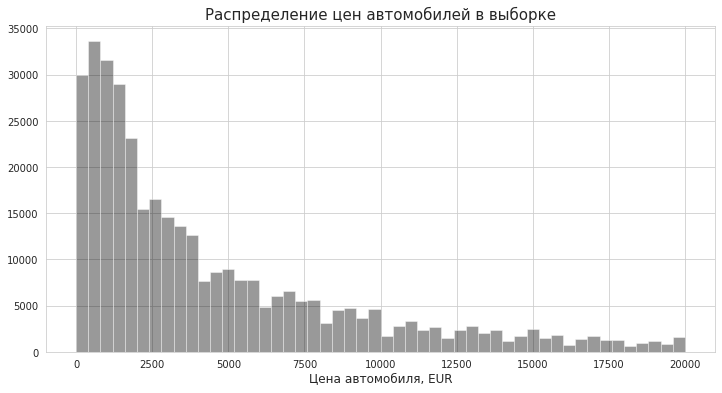

In [12]:
sns.set_style('whitegrid')

plt.figure(figsize=(12,6))
sns.distplot(cars['Price'], kde=False, color='black')

plt.xlabel('Цена автомобиля, EUR', size=12)
plt.title('Распределение цен автомобилей в выборке', size=15);

Как видим, бОльшая часть автомобилей находися в ценовой категории до 2 тысяч Евро. Максимальная цена, как уже отмечалось выше - 20000 Евро.  

Как отличается средняя цена за автомобиль в зависимости от года выпуска?

In [13]:
price_mean = (
    cars[['RegistrationYear', 'Price']]
    .groupby('RegistrationYear', as_index=False).mean()
    .astype('int')
)

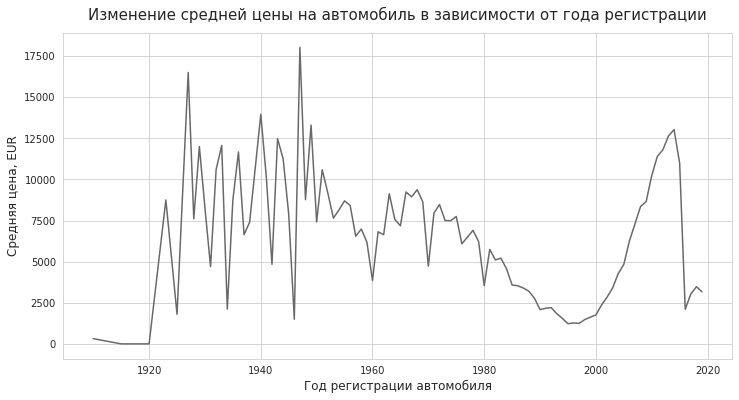

In [14]:
plt.figure(figsize=(12,6))
sns.lineplot(x='RegistrationYear', y='Price', data=price_mean, color='dimgray')
plt.xlabel('Год регистрации автомобиля', size=12)
plt.ylabel('Средняя цена, EUR', size=12)
plt.title('Изменение средней цены на автомобиль в зависимости от года регистрации', size=15, y=1.02);

Интересный тренд, что начиная с 60х годов средняя цена на автомобили постепенно падает до значений ~1,5 тыс Евро, после чего резко поднимается и так же молниеносно падает после 2015 года. Возможно, это связано с кризисом 16го и с тем, что люди перестали покупать и продавать дорогие машины.  

Высокие скачки средней цены в период с 1920 по 1950 года можно отчасти объяснить тем, что в выборке присутствует небольшой процент различных автомобилей того времени.  


Различается ли цена автомобилей по месяцам или годам выставление объявления на сайт? 
Первым делом выделям месяц и год создания анкеты и отделяем необходимые значение в отдельные столбцы.  

In [15]:
cars['DateCreated'] = pd.to_datetime(cars['DateCreated'], format='%Y-%m-%dT%H:%M:%S')
cars['MonthCreated'] = cars['DateCreated'].dt.weekday  

In [16]:
cars['YearCreated'] = cars['DateCreated'].dt.year  

In [17]:
cars['MonthCreated'].value_counts()

0    63258
5    57003
1    51381
6    48821
2    47255
3    45530
4    40950
Name: MonthCreated, dtype: int64

Интересно, подписчики сервиса продают автомобили только семь месяцев в году? Необходимо обратить на это внимание тимлида и отдела разработки.

In [18]:
temp = cars.groupby('MonthCreated')['Price'].median()
temp.head()

MonthCreated
0    2700
1    2500
2    2600
3    2650
4    2750
Name: Price, dtype: int64

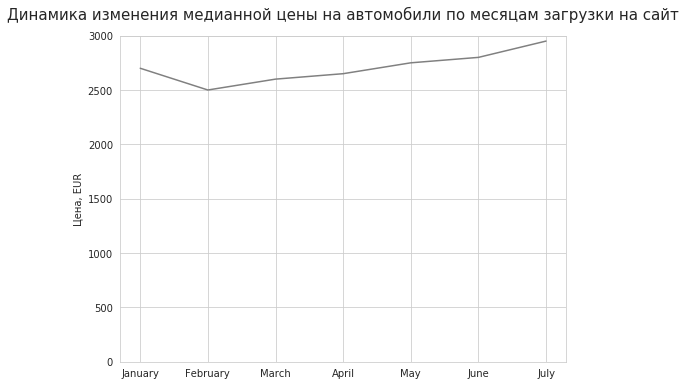

In [19]:
plt.figure(figsize=(8,6))
sns.lineplot(data=temp, color='gray')
plt.ylim(0,3000)
plt.xticks(np.arange(7), calendar.month_name[1:8])
plt.ylabel('Цена, EUR')
plt.title('Динамика изменения медианной цены на автомобили по месяцам загрузки на сайт', size=15, y=(1.03));

В феврале машины подешевле, к июлю дорожают максимально.  
Возможно, всем хочется поехать на дачу / природу и многие люди начинают покупать себе железных коней.  

А что по годам?

In [20]:
temp = cars.groupby('YearCreated')['Price'].agg(['median', 'count']).reset_index()
temp.head()

,YearCreated,median,count
0,2014,8999,1
1,2015,6000,25
2,2016,2700,354172


In [21]:
cars.query('YearCreated == 2016 and RegistrationYear >=2017').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,MonthCreated,YearCreated
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33,2,2016
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46,3,2016
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44,4,2016
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08,0,2016
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37,3,2016


**Так!**  
Почему у нас машина выставлена на продажу в 16 году, а поставлена на регистрацию в 18? Это вообше законно?  

И при этом юзер заходил последний раз в 2016 году? Тимлид, алло, алло, у нас проблемы!)  

И главная особенность - в 2014 году выставлена на продажу всего одна машина, в 2015 - 25 машин, в 2016 - 99,9% всей выборки. Ладно, оставим это на совести разработчиков сайта.  

---

Возвращаемся к предобработке.

### Заполнение пропусков  

##### Был ли автомобиль в ремонте

Как указывалось выше, предлагаю все пропущенные значения здесь заполнить строкой 'No'.  
Хотя можно предположить, что автомобили без указанного ремонта - очень старые автомобили, тогда можно, в принципе, задуматься о значениях 'yes' в данном столбце.  

Проверим гипотезу о том, что "не бита и не крашена" - это все старинные автомобили.

In [22]:
not_rep = cars.loc[cars['NotRepaired'].isna()]['RegistrationYear'].value_counts()
not_rep_perc = not_rep.head(10).sum() / cars.loc[cars['NotRepaired'].isna(), 'Price'].count()

print(not_rep.head(10))
print()
print('"Новые" автомобили без указания ремонта, составляют {:.2%} от общего количества'.format((not_rep_perc)))

2000    7286
1999    4849
2017    4594
2005    4452
2016    4426
1998    4074
2001    3616
1997    3571
1995    3328
2002    3160
Name: RegistrationYear, dtype: int64

"Новые" автомобили без указания ремонта, составляют 61.06% от общего количества


Гипотеза не подтверждена - большинство автомобилей относительно новые.  
Заменяем пропуски значениями 'no'

In [23]:
cars['NotRepaired'] = cars['NotRepaired'].fillna(value='no')

##### Коробка передач

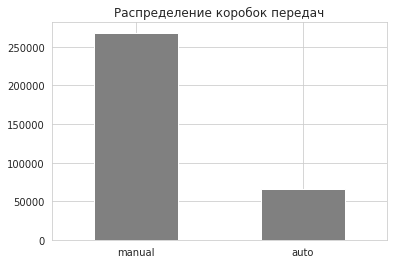

In [24]:
plt.figure()
cars['Gearbox'].value_counts().plot(kind='bar', color='grey')
plt.xticks(rotation=0)
plt.title('Распределение коробок передач');

"Ручных" коробок ~ в 4 раза больше, чем автоматических. При этом, как было отмечено выше, пропущенных значений ~5.5% от общего числа.  

Посмотрим на зависимость типа коробки от года выпуска

In [25]:
gb_dict = dict(manual=0, auto=1)

In [26]:
temp = cars[['Gearbox','RegistrationYear', 'Price']]

temp['Gearbox'] = temp['Gearbox'].replace(gb_dict)

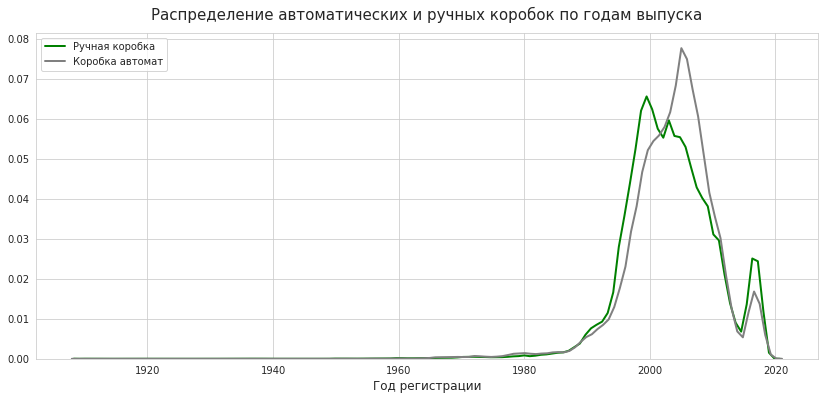

In [28]:
plt.figure(figsize=(14,6))

sns.distplot(temp.loc[temp['Gearbox']==0, 'RegistrationYear'], hist=False, 
             color='green', kde_kws={"lw": 2, "label": "Ручная коробка"})

sns.distplot(temp.loc[temp['Gearbox']==1, 'RegistrationYear'], hist=False, 
             color='gray', kde_kws={"lw": 2, "label": "Коробка автомат"})

plt.xlabel('Год регистрации', size=12)
plt.title('Распределение автоматических и ручных коробок по годам выпуска', size=15, y=(1.02));

Как видно, бОльшая часть "ручных" коробок пришлась на конех 90х годов, тогда, как пик "автоматов" наблюдается ближе к концу "нулевых". Интересный тренд, в 2010х стали вновь выпускать много машин с ручной коробкой.

---

С очень высокой вероятно можно предположить, что автомобили до 1945 комплектовались ручной коробкой

In [29]:
cars.ix[temp['RegistrationYear'] <= 1945, 'Gearbox'] =(
    cars.ix[temp['RegistrationYear'] <= 1945, 'Gearbox'].fillna('manual'))


In [30]:
cars.loc[cars['RegistrationYear'] <= 1945]['Gearbox']

15        manual
1928      manual
2273      manual
6629      manual
6977      manual
           ...  
338109    manual
343083    manual
346046    manual
353531    manual
353961    manual
Name: Gearbox, Length: 173, dtype: object

Возможно, более дорогие машины компановались автоматическими коробками.

In [31]:
temp_1 = temp.loc[temp['RegistrationYear'] > 1990]
temp_1['Price'].corr(temp_1['Gearbox'])

0.2536015276533009

In [32]:
temp_2 = temp.loc[temp['RegistrationYear'] > 2000]
temp_2['Price'].corr(temp_1['Gearbox'])

0.2617879083634774

Увы, данные корреляции очень слабые.  
Пока есть два варианта развития событий:  
1. Заполняем все пропуски 'manual' коробкой;
2. Заполняем пропуски новым типом 'unsorted'.  

Затем смотрим, какие данные позволяют построить более качественную модель.  

Хотя есть ее предположение, что тип коропки несильно влияет на цену, и, возможно, его можно будет вообще не учитывать при построении моделей.  

In [33]:
cars['GearboxUnsorted'] = cars['Gearbox'].fillna(value='unsorted')
cars['Gearbox'] = cars['Gearbox'].fillna('manual')

##### Модель автомобиля  

Посмотрим на количество незаполненных значений данной категории.

In [34]:
temp = pd.DataFrame(cars.groupby(['Brand'])['Model'].count()).reset_index()

temp.sort_values(by='Model', ascending=False).tail()

,Brand,Model
13,jaguar,491
17,lancia,448
28,rover,404
16,lada,210
33,sonstige_autos,0


Первое, что мы видим - странная марка sontige_autos - вообще не имеет моделей.  
Яндекс подсказал нам - что это словосочетание переводится с немецкого, как "другой автомобиль". Вероятно, марки такого автомобиля не было в базе сайта.

In [35]:
len(cars.query('Brand == "sonstige_autos"'))

3338

In [36]:
len(cars.loc[cars['Model']=="other"])

24403

Предлагаю модели "других автомобилей" заполнить значениями "оther", так как мы никак больше не восстановим (или я пока не знают таких методов) данные пропуски.

In [37]:
cars.loc[cars['Brand']=='sonstige_autos', 'Model'] = cars.loc[cars['Brand']=='sonstige_autos', 'Model'].fillna('other')

---

В данном случае - залью пропуски модели самыми частыми представителями по брендам.

In [38]:
mod_dict = cars.groupby(['Brand'])['Model'].apply(lambda x: x.mode()[0])

cars['Model'] = cars['Model'].fillna(cars['Brand'].map(mod_dict))

In [39]:
cars['Model'].isna().sum()

0

##### Тип кузова  

Вполне вероятно, что тип кузова автомобиля не влияет на цену. Однако, все равно заполним пропущенные значения.

Создаем словарь с наиболее часто встречающими значениями типа кузова, сгруппированных по моделям автомобилей. 
Заполняем этими значениями пропуски.

In [40]:
vt_dict = dict(cars.groupby(['Model'])['VehicleType'].apply(lambda x: x.mode()[0]))

cars['VehicleType'] = cars['VehicleType'].fillna(cars['Model'].map(vt_dict))

In [41]:
cars.isna().sum().sort_values().tail(2)

RegistrationMonth        0
FuelType             32767
dtype: int64

##### Тип топлива  

Посмотрим, на все доступные типы топлива (вдруг, там есть уголь).

In [42]:
cars['FuelType'].value_counts()

petrol      216318
gasoline     98713
lpg           5310
cng            564
hybrid         233
other          203
electric        90
Name: FuelType, dtype: int64

Неть. Но есть электрокары, гибриды, сжиженные углеводороды и газ. 

В данном случае забьем пропуски по марке автомобиля.

In [43]:
fuel_dict = cars.groupby(['Model'])['FuelType'].apply(lambda x: x.mode()[0])

np.unique(fuel_dict.values)

array(['gasoline', 'petrol'], dtype=object)

Интерено, насколько качественно такое заполнение.  
Но пока ничего лучше придумать не могу.  

Хотя в нашей выборке все машины достаточно дешевые (а стоимость гибридов и электрокаров пока высока), возможно, данный метод является самым адекватным.

In [44]:
cars['FuelType'] = cars['FuelType'].fillna(cars['Model'].map(fuel_dict))

---

##### Обработка дубликатов

In [46]:
cars[cars.duplicated(keep="first")].count()

DateCrawled          5
Price                5
VehicleType          5
RegistrationYear     5
Gearbox              5
Power                5
Model                5
Kilometer            5
RegistrationMonth    5
FuelType             5
Brand                5
NotRepaired          5
DateCreated          5
NumberOfPictures     5
PostalCode           5
LastSeen             5
MonthCreated         5
YearCreated          5
GearboxUnsorted      5
dtype: int64

В начальном сете 5 строк - полных дубликатов. Удаляем их.

In [47]:
cars = cars.drop_duplicates()

##### Проверка мощности

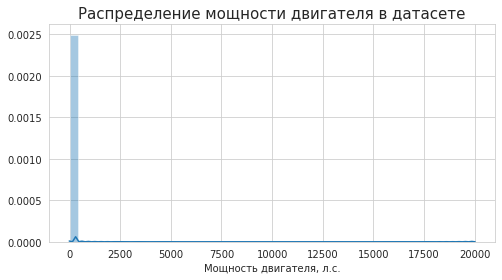

In [48]:
plt.figure(figsize=(8,4))
sns.distplot(cars['Power'])
plt.xlabel('Мощность двигателя, л.с.')
plt.title('Распределение мощности двигателя в датасете',size=15);

О ма гад! Есть как нулевые значения, так и очень высокие! 20000 лс - это почти четверть от мощности ледокола "50 лет Победы"!   
Попробуем построить боксплот с медианой без выбросов

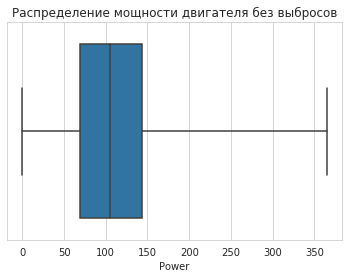

In [49]:
sns.boxplot(cars['Power'], showfliers=False, whis=3)
plt.title('Распределение мощности двигателя без выбросов');

Тройной межквартильный размах вобрал в себя значения от нуля до ~370. Однако, в свободном доступе есть автомобили и мощнее.
Можно выкинуть из сета значения, превышающие порог 500.  

Однако, есть еще одно предположение - точно удалить строки со значениями выше 10000 лс.   

И похоже на то, что сбита кодировка мощности на сайте или невозможно вбить значения мощности с долями процента. Табличка ниже показывает, что, например, у короллы 2004 года указана мощность в 1398 лс, на самом деле - нормальная мощность такого типа автомобилей - 110-132 лс. https://auto.ru/sankt-peterburg/cars/toyota/corolla/2004-year/all/?sort=fresh_relevance_1-desc  . Смарт "надвоих" так же подходит под данное определение https://auto.ru/sankt-peterburg/cars/smart/fortwo/all/?sort=fresh_relevance_1-desc&year_from=2017  
У большинства машин с "завышенной" мощностью такой подход так же работает.  

Итого, предлагаю значения мощности 600-5000 - разделить на 10 (получаем диапазон 60-500),  
Значения мощности в диапазоне 5001-9999 - разделить на 100 (получаем диапазон 50-90). 

Более 46 тысяч записей имею мощность менее 50 л.с. Что очень странно. Предлагаю заполнить эти значения группировкой по модели, как это делалось выше.


In [50]:
cars.query('Power > 500').head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,MonthCreated,YearCreated,GearboxUnsorted
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26,1,2016,manual
2102,2016-03-21 11:55:22,0,sedan,1999,manual,1799,vectra,150000,1,petrol,opel,yes,2016-03-21,0,1723,2016-04-04 04:49:06,0,2016,unsorted
3746,2016-03-21 14:48:31,0,small,2017,manual,750,fortwo,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59,0,2016,manual
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03,0,60326,2016-04-07 14:56:46,6,2016,manual
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,no,2016-03-29,0,33154,2016-04-06 05:44:36,1,2016,manual
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31,0,44379,2016-04-01 03:41:52,3,2016,manual
6504,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,no,2016-03-14,0,40721,2016-03-14 15:54:34,0,2016,manual
6637,2016-03-31 19:48:22,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes,2016-03-31,0,70327,2016-04-06 14:17:51,3,2016,manual
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,no,2016-04-02,0,65830,2016-04-06 11:46:49,5,2016,manual
7720,2016-04-02 11:48:54,1500,small,2000,manual,1400,civic,150000,0,petrol,honda,no,2016-04-02,0,21509,2016-04-04 09:15:26,5,2016,manual


In [52]:
def pow_norm(row):
    
    power = row['Power']
    
    if 600 <= power <= 5000:
        return power / 10
    if 5001 <= power <= 9999:
        return power / 100
    if power < 50:
        return np.nan
    else:
        return power

In [53]:
cars['Power_upd'] = cars.apply(pow_norm, axis=1)

In [54]:
cars.iloc[1815]

DateCrawled          2016-03-22 20:52:00
Price                               3200
VehicleType                        small
RegistrationYear                    2004
Gearbox                           manual
Power                               1398
Model                            corolla
Kilometer                           5000
RegistrationMonth                      6
FuelType                          petrol
Brand                             toyota
NotRepaired                           no
DateCreated          2016-03-22 00:00:00
NumberOfPictures                       0
PostalCode                         22043
LastSeen             2016-03-22 21:43:26
MonthCreated                           1
YearCreated                         2016
GearboxUnsorted                   manual
Power_upd                          139.8
Name: 1816, dtype: object

In [55]:
cars['Power_upd'].isna().sum()

46040

In [56]:
cars = cars.drop(cars.loc[cars['Power']>=10000].index)

In [57]:
cars['Power_upd'] = cars.groupby('Model')['Power_upd'].transform(lambda x: x.fillna(value=x.median()))

In [58]:
print('Пропуски значений мощности', cars['Power_upd'].isna().sum())
print('Нулевая мощность', len(cars[cars['Power_upd']==0]))

Пропуски значений мощности 2
Нулевая мощность 0


In [59]:
cars[cars['Power_upd'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,MonthCreated,YearCreated,GearboxUnsorted,Power_upd
234296,2016-03-30 11:39:08,3800,wagon,1978,manual,0,serie_1,30000,0,gasoline,land_rover,no,2016-03-30,0,49824,2016-03-30 11:39:08,2,2016,manual,NaN
280216,2016-04-02 10:53:15,0,wagon,1970,manual,0,serie_1,100000,0,petrol,land_rover,no,2016-04-02,0,88634,2016-04-06 09:16:22,5,2016,unsorted,NaN


Просто удалим две записи с пропущенной мощностью.

In [60]:
cars = cars.drop(cars[cars['Power_upd'].isna()].index)
cars['Power_upd'] = cars['Power_upd'].astype('int')

In [61]:
print('Пропуски значений мощности', cars['Power_upd'].isna().sum())

Пропуски значений мощности 0


Гуд.  
Посмотрим на распределение мощности теперь.

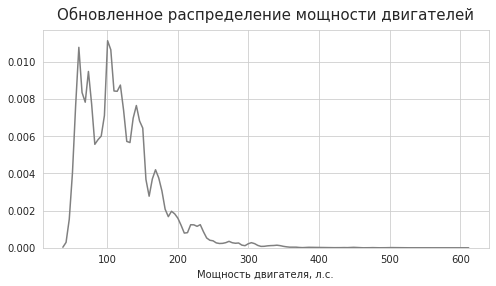

In [62]:
plt.figure(figsize=(8,4))

sns.distplot(cars['Power_upd'], color='gray', hist=False)

plt.xlabel('Мощность двигателя, л.с.')
plt.title('Обновленное распределение мощности двигателей',size=15, y=(1.02));

Теперь предобработка проведена полностью.

Возвращаемся к обучению.  

---

In [45]:
cars.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
MonthCreated         0
YearCreated          0
GearboxUnsorted      0
dtype: int64

Пропущенных значений не осталось. Переходим к выводам и следующему шагу.

### Вывод 

На данном этапе был произведен анализ данных и предобработка пропущенных значений.  
В первую очередь было выдвинуто предположение об исключении фич с датами регистрации анкеты, последнего визита пользователя, количества фотографий и даты снятия анкеты, поскольку они имеют корреляцию с ценой автомобиля (напомню, что фотографий вообше не было, все значения = 0).  
В ходе анализа установлено, что бОльшая часть автомобилей лежит в ценовой категории 1,5 тыс Евро, встречаются образцы и за 20 тысяч. Несколько тысяч автомобилей не попали под имеющиеся категории марок и были оставлены в сете, как 'sonstige_autos".  
Так же в ходе данного шага были обработаны все пропуенные значения, в основном, на основании группировки сета по модели, году регистрации и марке автомобиля.  

Предобработка и анализ данных завершен, переходим к обучению и тестированию моделей.  


---

## Шаг 2. Обучение моделей  

Первым делом разобьем имеющиеся данные на обучающую и тестовую выборку, a так же установим значение random_state.   
Удалим неинформативные признаки и ненужный теперь первичный столбец Power.

In [71]:
RND_ST = 42

In [77]:
unnec_col = ['Price', 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen', 'MonthCreated', 'YearCreated', 'GearboxUnsorted', 'Power']

features = cars.drop(unnec_col, axis=1)
target = cars['Price']

In [78]:
features.head()

,VehicleType,RegistrationYear,Gearbox,Model,Kilometer,FuelType,Brand,NotRepaired,Power_upd
0,sedan,1993,manual,golf,150000,petrol,volkswagen,no,101
1,coupe,2011,manual,a4,125000,gasoline,audi,yes,190
2,suv,2004,auto,grand,125000,gasoline,jeep,no,163
3,small,2001,manual,golf,150000,petrol,volkswagen,no,75
4,small,2008,manual,fabia,90000,gasoline,skoda,no,69


In [85]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=RND_ST)

Из обучающей выборки вытянем валидационную.

In [86]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=RND_ST)

In [87]:
print(X_train.shape[0], X_valid.shape[0], X_test.shape[0])

212487 70829 70830


#### Dummy model

В данном спринте разберем применение четырех моделей.  
Но для начала позовем дамми регрессора, для дальнейшей проверки моделей на адекватность.  
Передадим нашему первому регрессору средние значения цены.  

Требуемая функция подсчета времени выполнения ячейки из задания представлена ниже.

In [89]:
%%time

dummy = DummyRegressor(strategy='mean')

dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_valid)

rmse_dr = np.around(np.sqrt(mean_squared_error(y_valid, y_pred)),3)
print('RMSE дамми регрессора со средним прогнозом цен на валидационной выборке = {}'.format(rmse_dr))
print()

RMSE дамми регрессора со средним прогнозом цен на валидационной выборке = 4507.32

CPU times: user 3.82 ms, sys: 0 ns, total: 3.82 ms
Wall time: 2.6 ms


Наш дамми малыш ошибается, в среднем, на 4,5 тысячи Евро, однако, работает очень быстро.  


---

#### Создание скоринга RMSE

На данном шаге мы сразу будем подбирать гиперпараметры и фиксировать лучшее значение метрики RMSE.  

Так как в текущей версии Тренажера нет функции squared=False в скоринге MSE, пропишем этот скоринг с нуля

In [90]:
def rmse(targets, predictions):
    return np.sqrt(((predictions - targets) ** 2).mean())

RMSE_SCORE = make_scorer(rmse, greater_is_better=False)

Проверим его работу, вызовем простенький регрессор и попробуем найти гиперпараметры

In [93]:
features_ = pd.get_dummies(features, drop_first=True)
target_ = cars['Price'] 

X_train_val, X_test_, y_train_val, y_test_ = train_test_split(features_, target_, test_size=0.2, random_state=RND_ST)
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=RND_ST)

print(X_train_.shape[0], X_valid_.shape[0], X_test_.shape[0])

212487 70829 70830


In [98]:
X_train_.shape[1]

305

In [99]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=RND_ST)

dtr_params = dict(max_depth=[5,6,7], 
                 max_features=[2,3,4])

Напишем функцию рандомного поиска гиперпараметров (пригодится и в дальнейшем)

In [100]:
def rand_search(model, grid, feat, targ):
    
    search = RandomizedSearchCV(model, grid, cv=5, scoring=RMSE_SCORE, n_jobs=-1)
    search.fit(feat, targ)
    
    print(search.best_score_ * -1)
    print(search.best_params_)

In [101]:
rand_search(dtr, dtr_params, X_train_, y_train_)

3860.504667722995
{'max_features': 2, 'max_depth': 5}


In [112]:
def rmse_score(model, X, y):
    
    y_pred = model.predict(X)

    score = rmse(y, y_pred)
    
    return(score)

In [114]:
dtr = DecisionTreeRegressor(random_state=RND_ST, max_features=2, max_depth=5)

dtr.fit(X_train_, y_train_)

print('Валидационная выборка', rmse_score(dtr, X_valid_, y_valid_))
print('Тестовая выборка', rmse_score(dtr, X_test_, y_test_))

Валидационная выборка 3730.570706937853
Тестовая выборка 3762.799036244059


Так судя по всему наш скоринг работает модель ошибается в среднем на 4,2 тысячи Евро, что немного лучше, чем Дамми моделька.

Важно. Здесь вывод финального скора я умножил на -1, для того, чтобы реальное значение удовлетворяло условию возведения в квадрат. 

---

#### Gradient Boosting  

Начнем с обычного градиентного бустинга из sklearn.  
Стоит отметить, что для его применения, необходимо перевести все категориальные показатели в числовые, используя dummy преобразование или OneHotEncoding

В идеале настроить бустинг двумя серчами - на первом этапе подобрать количество деревьев, на втором - подогнать остальные параметры. Но Тренажер не обладает требуемой для быстрой работы мощностью.

In [117]:
gbr = GradientBoostingRegressor(random_state=RND_ST)

gbr_params_nest = dict(n_estimators=range(50,500,25))

gbr_params_other = dict(learning_rate=[0.1,0.5,1],
                        max_depth=[2,3,4])

In [119]:
#rand_search(gbr, gbr_params_nest, X_train_, y_train_)

Это так же оказалось слишком долгим на тренажере (первая операция потребовала >15 минут). Попробую вручную подобрать параметры =/.

In [120]:
#%%time

#gbr_1 = GradientBoostingRegressor(random_state=RND_ST, n_estimators=250, learning_rate=0.1, max_depth=3, verbose=50)
#gbr_1.fit(X_train_, y_train_)

      Iter       Train Loss   Remaining Time 
         1    18239634.1409           10.72m
         2    16506490.7528           10.69m
         3    15094424.3467           10.87m
         4    13848352.0195           10.88m
         5    12731358.0829           10.60m
         6    11847044.0916           10.71m
         7    11034082.0774           10.73m
         8    10402608.9952           10.76m
         9     9799276.5912           10.59m
        10     9322658.5192           10.59m
        11     8826645.2702           10.36m
        12     8392617.4007           10.22m
        13     8091335.9327           10.18m
        14     7765475.1829           10.08m
        15     7528942.5527           10.03m
        16     7284144.7478            9.98m
        17     7073285.9350            9.91m
        18     6870693.0536            9.75m
        19     6717712.5541            9.63m
        20     6587057.5887            9.59m
        21     6467361.3961            9.48m
        2

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=250,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=50,
                          warm_start=False)

**Время обучения**  6 min 11 sec - 371 sec  
**Train loss** = 3930568,8

In [124]:
#%%time
#print('RMSE на обучающей выборке', rmse_score(gbr_1, X_train_, y_train_))
#print()

RMSE на обучающей выборке 1982.5662217682325

CPU times: user 2.92 s, sys: 196 ms, total: 3.11 s
Wall time: 3.11 s


In [125]:
#%%time
#print('RMSE на валидационной выборке', rmse_score(gbr_1, X_valid_, y_valid_))
#print()

RMSE на валидационной выборке 2006.0632865173493

CPU times: user 790 ms, sys: 68.1 ms, total: 858 ms
Wall time: 856 ms


Без сильного подбора гиперпараметров удалось на валидационной выборке улучшить качество, относительно первоначального, до 2006 Евро (метрика RMSE). Посмотрим, что смогут сделать другие модели.  

Результаты исследования для наглядности соберем в отдельный фрейм.  

In [162]:
res = {
    'model_name':pd.Series(['GradBoost','xgboost','lightGBM','CatBoost']),
    'training_time':pd.Series([371,0,0,0]),
    'prediction_valid_time':pd.Series([858,0,0,0]), 
    'rmse_valid':pd.Series([2006,0,0,0]), 
    'prediction_test_time':pd.Series([0,0,0,0]), 
    'rmse_test':pd.Series([0,0,0,0])}

In [163]:
results = pd.DataFrame(res)
results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,GradBoost,371,858,2006,0,0
1,xgboost,0,0,0,0,0
2,lightGBM,0,0,0,0,0
3,CatBoost,0,0,0,0,0


   **Итог GradientBoosting**

Обучение - 371 сек  
Предсказание на валидации - 0858 мсек  
RMSE на валидации - 2006.  
Переобучения не обнаружено.

---

#### XGboost

In [140]:
dtrain = xgb.DMatrix(X_train_, label=y_train_)
dval = xgb.DMatrix(X_valid_)
dtest = xgb.DMatrix(X_test_)

In [152]:
%%time
param = {'max_depth':3, 
         'eta':1, 
         'sampling_method':'gradient_based', 
         'verbosity':1, 
         'gamma':10, 
         'seed':RND_ST}

num_round = 30

bst = xgb.train(param, dtrain, num_round)

CPU times: user 1min 14s, sys: 82.6 ms, total: 1min 14s
Wall time: 1min 15s


Как же быстро учится xgboost. Всего 50 секунд. Посмотрим на результаты.

In [153]:
%%time
print('RMSE на обучающей выборке', rmse_score(bst, dtrain, y_train_))
print()

RMSE на обучающей выборке 2074.7795804530724

CPU times: user 41.6 ms, sys: 3.58 ms, total: 45.2 ms
Wall time: 8.68 ms


In [154]:
%%time
print('RMSE на валидационной выборке', rmse_score(bst, dval, y_valid_))
print()

RMSE на валидационной выборке 2098.706310996195

CPU times: user 245 ms, sys: 4.04 ms, total: 249 ms
Wall time: 209 ms


Учится в разы быстрее, результат на обучающей и валидационной выборках ~ равен GradientBoosting'у.  

Еще немного поиграем с параметрами.

In [157]:
%%time
param = {'max_depth':6, 
         'eta':0.5, 
         'min_child_weight':4,
         'sampling_method':'gradient_based', 
         'verbosity':1,  
         'seed':RND_ST}

num_round = 35

bst = xgb.train(param, dtrain, num_round)

CPU times: user 2min 37s, sys: 241 ms, total: 2min 37s
Wall time: 2min 38s


In [158]:
%%time
print('RMSE на обучающей выборке', rmse_score(bst, dtrain, y_train_))
print()

RMSE на обучающей выборке 1835.402423318687

CPU times: user 44.5 ms, sys: 0 ns, total: 44.5 ms
Wall time: 8.74 ms


In [159]:
%%time
print('RMSE на валидационной выборке', rmse_score(bst, dval, y_valid_))
print()

RMSE на валидационной выборке 1908.5250873970024

CPU times: user 342 ms, sys: 539 µs, total: 342 ms
Wall time: 306 ms


Удалось улучшить RMSE на валидационной выборке, в сравнении с Gradient boosting, пусть и не намного.  
Однако, заметро улучшилось время обучения и предсказания.

In [167]:
results.loc[1,'training_time'] = 158
results.loc[1,'prediction_valid_time'] = 342
results.loc[1,'rmse_valid'] = 1908.5

In [169]:
results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,GradBoost,371,858,2006.0,0,0
1,xgboost,158,342,1908.5,0,0
2,lightGBM,0,0,0.0,0,0
3,CatBoost,0,0,0.0,0,0


**Итог xgbost**

Обучение - 158 сек  
Предсказание на валидации - 342 мсек  
RMSE на валидации - 1908,5.  
Переобучения не обнаружено. Заметно легкое недообучение.

---

#### LightGBM  

Переводим категориальные признаки из 'str' в 'int'

In [199]:
features_light = features.copy()

In [206]:
features.head()

,VehicleType,RegistrationYear,Gearbox,Model,Kilometer,FuelType,Brand,NotRepaired,Power_upd
0,sedan,1993,manual,golf,150000,petrol,volkswagen,no,101
1,coupe,2011,manual,a4,125000,gasoline,audi,yes,190
2,suv,2004,auto,grand,125000,gasoline,jeep,no,163
3,small,2001,manual,golf,150000,petrol,volkswagen,no,75
4,small,2008,manual,fabia,90000,gasoline,skoda,no,69


In [200]:
features_light.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'Kilometer',
       'FuelType', 'Brand', 'NotRepaired', 'Power_upd'],
      dtype='object')

In [201]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [202]:
cat_feat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

features_light[cat_feat] = enc.fit_transform(features_light[cat_feat]).astype('int')

In [204]:
features_light.head()

,VehicleType,RegistrationYear,Gearbox,Model,Kilometer,FuelType,Brand,NotRepaired,Power_upd
0,4,1993,1,116,150000,6,38,0,101
1,2,2011,1,29,125000,2,1,1,190
2,6,2004,0,117,125000,2,14,0,163
3,5,2001,1,116,150000,6,38,0,75
4,5,2008,1,101,90000,2,31,0,69


Создаем три подвыборки.

In [209]:
X_train_val_l, X_test_l, y_train_val_l, y_test_l = train_test_split(
    features_light, target, test_size=0.2, random_state=RND_ST)

 
X_train_l, X_valid_l, y_train_l, y_valid_l = train_test_split(
    X_train_val_l, y_train_val_l, test_size=0.25, random_state=RND_ST)


print(X_train_l.shape[0], X_valid_l.shape[0], X_test_l.shape[0])

212487 70829 70830


In [ ]:
train_data = lgb.Dataset(X_train_l, y_train_l, categorical_feature=cat_feat)
valid_data = lgb.Dataset(X_valid_l, categorical_feature=cat_feat) 
test_data = lgb.Dataset(X_test_l, categorical_feature=cat_feat)

Укажем первичные параметры.

In [213]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    #'max_depth':15,
    'num_leaves': 127,
    'min_data_in_leaf':100,
    'metric':'rmse',
    'learning_rate': 1,
    #'feature_fraction': 0.8,
    #'bagging_fraction': 0.5,
    'verbose': 1
}

In [214]:
%%time
gbm = lgb.train(params,
                train_data,
                num_boost_round=30)

CPU times: user 28.7 s, sys: 81.5 ms, total: 28.8 s
Wall time: 29.1 s


In [219]:
%%time
print('RMSE на обучающей выборке', rmse_score(gbm, X_train_l, y_train_l))
print()

RMSE на обучающей выборке 1668.8563096403889

CPU times: user 1.25 s, sys: 135 µs, total: 1.25 s
Wall time: 1.23 s


In [228]:
%%time
print('RMSE на валидационной выборке', rmse_score(gbm, X_valid_l, y_valid_l))
print()

RMSE на валидационной выборке 1760.0922516596775

CPU times: user 2.65 s, sys: 4.09 ms, total: 2.65 s
Wall time: 2.6 s


Заметно сильное переобучение модели. Однако скорость обучения и rmse на валидационной выборке лучше предыдущиз двух моделей.  

Еще поиграем с гиперпараметрами.

In [225]:
params_upd = {
    'boosting_type': 'gbdt',
    'tree_learner':'feature',
    'objective': 'regression',
    #'max_depth':12,
    'num_leaves': 300,
    #'min_data_in_leaf':300,
    'max_bin':100,
    'learning_rate': 0.35,
    'num_iteration':150,
    'metric':'rmse',
    'verbose': 1
}

In [226]:
%%time
gbm = lgb.train(params_upd,
                train_data,
                num_boost_round=45)

CPU times: user 2min 34s, sys: 733 ms, total: 2min 35s
Wall time: 2min 36s


In [227]:
%%time
print('RMSE на обучающей выборке', rmse_score(gbm, X_train_l, y_train_l))
print()

RMSE на обучающей выборке 1325.6997046051652

CPU times: user 7.85 s, sys: 7.53 ms, total: 7.86 s
Wall time: 7.77 s


In [229]:
%%time
print('RMSE на валидационной выборке', rmse_score(gbm, X_valid_l, y_valid_l))
print()

RMSE на валидационной выборке 1760.0922516596775

CPU times: user 2.63 s, sys: 3.63 ms, total: 2.63 s
Wall time: 2.62 s


Cнова удалось улучшить RMSE на валидационной выборке, в сравнении с предыдущими моделями.
Чуть хуже стало время предсказания.


In [274]:
results.loc[2,'training_time'] = 155
results.loc[2,'prediction_valid_time'] = 2630
results.loc[2,'rmse_valid'] = 1760.1

In [235]:
results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,GradBoost,371,858,2006.0,0,0
1,xgboost,158,342,1908.5,0,0
2,lightGBM,156,2620,1760.1,0,0
3,CatBoost,0,0,0.0,0,0


**Итог LightGBM**

Обучение - 155 сек  
Предсказание на валидации - 2630 мсек  
RMSE на валидации - 1760.1.  
Заметно переобучение.

---

#### CatBoost  

Категориальные фичи-значения ('str') теперь можно не переводить в цифровые!  
Снова создаем три подвыборки.

In [238]:
X_train_val_c, X_test_c, y_train_val_c, y_test_c = train_test_split(
    features, target, test_size=0.2, random_state=RND_ST)

 
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(
    X_train_val_c, y_train_val_c, test_size=0.25, random_state=RND_ST)


print(X_train_c.shape[0], X_valid_c.shape[0], X_test_c.shape[0])

212487 70829 70830


In [239]:
X_train_c.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'Kilometer',
       'FuelType', 'Brand', 'NotRepaired', 'Power_upd'],
      dtype='object')

Создаем три пула.

In [241]:
train_pool = Pool(X_train_c, 
                  y_train_c, 
                  cat_features=cat_feat)

valid_pool = Pool(X_valid_c, 
                  y_valid_c, 
                  cat_features=cat_feat)

test_pool = Pool(X_test_c, 
                 cat_features=cat_feat) 

Обьявляем и обучаем модедь.

In [242]:
cbr = CatBoostRegressor(depth=6, 
                        learning_rate=1, 
                        loss_function='RMSE', 
                        verbose=50, 
                        random_state=RND_ST, 
                        iterations=500)

In [243]:
%%time
cbr.fit(train_pool)

0:	learn: 2749.6263915	total: 749ms	remaining: 6m 13s
50:	learn: 1867.8407471	total: 28.8s	remaining: 4m 13s
100:	learn: 1796.0685561	total: 54.6s	remaining: 3m 35s
150:	learn: 1757.6578815	total: 1m 20s	remaining: 3m 6s
200:	learn: 1730.1046978	total: 1m 46s	remaining: 2m 38s
250:	learn: 1705.2820509	total: 2m 14s	remaining: 2m 13s
300:	learn: 1688.7381177	total: 2m 40s	remaining: 1m 46s
350:	learn: 1669.3618698	total: 3m 7s	remaining: 1m 19s
400:	learn: 1653.3333799	total: 3m 34s	remaining: 53.1s
450:	learn: 1637.4716407	total: 4m 1s	remaining: 26.3s
499:	learn: 1625.3526647	total: 4m 27s	remaining: 0us
CPU times: user 3min 59s, sys: 30.5 s, total: 4min 29s
Wall time: 4min 33s


277 секунд обучения. Долго, по посмотрим на качество предсказаний.

In [244]:
%%time
print('RMSE на обучающей выборке', rmse_score(cbr, X_train_c, y_train_c))
print()

RMSE на обучающей выборке 1655.0148681679614

CPU times: user 2.28 s, sys: 63.4 ms, total: 2.35 s
Wall time: 2.31 s


In [245]:
%%time
print('RMSE на валидационной выборке', rmse_score(cbr, X_valid_c, y_valid_c))
print()

RMSE на валидационной выборке 1842.1329724102134

CPU times: user 791 ms, sys: 8.28 ms, total: 800 ms
Wall time: 742 ms


Средний показатель, попробуем еще понастраивать параметры.

In [258]:
cbr_1 = CatBoostRegressor(depth=7, 
                        learning_rate=0.1, 
                        loss_function='RMSE', 
                        verbose=50, 
                        l2_leaf_reg=10,
                        random_state=RND_ST, 
                        iterations=400)

In [259]:
%%time
cbr_1.fit(train_pool)

0:	learn: 4226.4999862	total: 743ms	remaining: 4m 56s
50:	learn: 2014.4589545	total: 33.4s	remaining: 3m 48s
100:	learn: 1929.1803897	total: 1m 4s	remaining: 3m 12s
150:	learn: 1879.8744773	total: 1m 37s	remaining: 2m 40s
200:	learn: 1849.2350892	total: 2m 8s	remaining: 2m 7s
250:	learn: 1829.2721637	total: 2m 40s	remaining: 1m 35s
300:	learn: 1811.5378275	total: 3m 11s	remaining: 1m 3s
350:	learn: 1799.6280152	total: 3m 42s	remaining: 31.1s
399:	learn: 1790.2170234	total: 4m 12s	remaining: 0us
CPU times: user 3min 45s, sys: 28.8 s, total: 4min 13s
Wall time: 4min 17s


In [260]:
%%time
print('RMSE на обучающей выборке', rmse_score(cbr_1, X_train_c, y_train_c))
print()

RMSE на обучающей выборке 1790.1596560592354

CPU times: user 1.47 s, sys: 59.3 ms, total: 1.53 s
Wall time: 1.54 s


In [261]:
%%time
print('RMSE на валидационной выборке', rmse_score(cbr_1, X_valid_c, y_valid_c))
print()

RMSE на валидационной выборке 1841.793468076695

CPU times: user 509 ms, sys: 15.4 ms, total: 525 ms
Wall time: 483 ms


Улучшили метрику RMSE на 1 пункт! Победа, однозначно.  
Замечено, что на локальной машине катбуст считает качественнее - на данном примере дома рмсе = 1753 на валидационной выборке.

In [273]:
results.loc[3,'training_time'] = 253
results.loc[3,'prediction_valid_time'] = 525
results.loc[3,'rmse_valid'] = 1841.8

In [264]:
results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,GradBoost,371,858,2006.0,0,0
1,xgboost,158,342,1908.5,0,0
2,lightGBM,156,2620,1760.1,0,0
3,CatBoost,257,483,1841.8,0,0


**Итог CatBoost**

Обучение - 257 сек  
Предсказание на валидации - 483 мсек  
RMSE на валидации - 1841.8  
Заметно переобучение.

---

Переходим к выводам.

---

### Вывод 

На данном шаге было проведено тестирование пяти моделей:  
1. Дамми болванка  
2. Градиентный бустинг sklearn  
3. xgboost  
4. LightGBM  
5. CatBoost  

Быстрее всех учится и предсказывает xgboost, занимая при этом третье место по качеству предсказаний. Наилучшую метрику rmse на валидационной выборке показал LightGBM, однако время его предсказаний - самое долгое из всех моделей.  

В целом, сейчас уже можно выбросить из конкурса GradientBoosting, однако, произведем замеры rmse всех моделей на тестовой выборке. 

---

## Шаг 3. Анализ моделей

На данном этапе определим метрику rmse всех моделей на оставшейся тестовой выборке.

In [265]:
%%time
print('RMSE GradBoost на тестовой выборке', rmse_score(gbr_1, X_test_, y_test_))
print()

RMSE GradBoost на тестовой выборке 2012.429379834758

CPU times: user 745 ms, sys: 69.4 ms, total: 814 ms
Wall time: 812 ms


In [267]:
%%time
print('RMSE xgboost на тестовой выборке', rmse_score(bst, dtest, y_test_))
print()

RMSE xgboost на тестовой выборке 1914.7348889377138

CPU times: user 335 ms, sys: 4.16 ms, total: 339 ms
Wall time: 302 ms


In [268]:
%%time
print('RMSE LightGBM на тестовой выборке', rmse_score(gbm, X_test_l, y_test_l))
print()

RMSE LightGBM на тестовой выборке 1767.1121813042364

CPU times: user 2.66 s, sys: 0 ns, total: 2.66 s
Wall time: 2.55 s


In [269]:
%%time
print('RMSE CatBoost на тестовой выборке', rmse_score(cbr_1, X_test_c, y_test_c))
print()

RMSE CatBoost на тестовой выборке 1844.7409468140431

CPU times: user 545 ms, sys: 6.77 ms, total: 551 ms
Wall time: 470 ms


Соберем все данные в таблицу результатов.  

In [271]:
results.loc[0,'prediction_test_time'] = 814
results.loc[0,'rmse_test'] = 2012.4

results.loc[1,'prediction_test_time'] = 339
results.loc[1,'rmse_test'] = 1914.7

results.loc[2,'prediction_test_time'] = 2660
results.loc[2,'rmse_test'] = 1767.1

results.loc[3,'prediction_test_time'] = 551
results.loc[3,'rmse_test'] = 1844.7

In [322]:
results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,GradBoost,371,858,2006.0,814,2012.4
1,xgboost,158,342,1908.5,339,1914.7
2,lightGBM,155,2630,1760.1,2660,1767.1
3,CatBoost,253,525,1841.8,551,1844.7


In [324]:
temp = results.copy().sort_values(by=['rmse_test'])
temp

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
2,lightGBM,155,2630,1760.1,2660,1767.1
3,CatBoost,253,525,1841.8,551,1844.7
1,xgboost,158,342,1908.5,339,1914.7
0,GradBoost,371,858,2006.0,814,2012.4


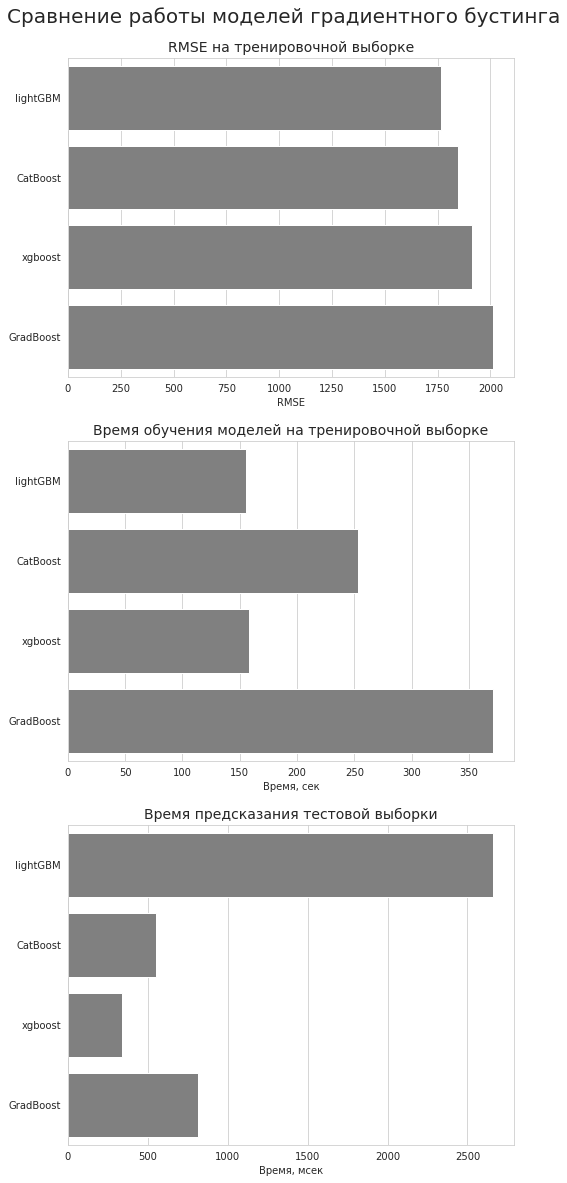

In [345]:
fig, axes = plt.subplots(3,1 , figsize=(8,20))

sns.barplot(y=temp['model_name'], x=temp['rmse_test'], color='gray', ax=axes[0], orient='h')
sns.barplot(y=temp['model_name'], x=temp['training_time'], color='gray', ax=axes[1], orient='h')
sns.barplot(y=temp['model_name'], x=temp['prediction_test_time'], color='gray', ax=axes[2], orient='h')

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')

axes[0].set_xlabel('RMSE')
axes[1].set_xlabel('Время, сек')
axes[2].set_xlabel('Время, мсек')

axes[0].set_title('RMSE на тренировочной выборке', size=14)
axes[1].set_title('Время обучения моделей на тренировочной выборке', size=14)
axes[2].set_title('Время предсказания тестовой выборки', size=14)

plt.suptitle('Сравнение работы моделей градиентного бустинга', size=20, y=(0.915));

Все модели показали "средние" результаты.  
Можно лучше настроить гиперпараметры, вероятно. И так же заняться более глубоким features engeneering.  

Лидером по качеству предсказаний становится LightGBM, самая быстрая модель обучения и предсказания - xgboost.

Итог - наилучшее решение - модель LightGBM - средняя скорость работы и лучшее качество.

### Вывод  

На данном этапе были проанализированны 4 модели. Приемлемой моделью признана LightGBM, с наилучшими показателями RMSE и достаточно хорошим временем работы, относительно других моделей.  

---

### Общий вывод 

Целью настоящего исследования ставилось тестирование и подбор наилучшей модели для имеющихся данных.  

В исследовании приняли участие 4 модели : 'LightGBM', 'Catboost', 'Gradient_Boosting', 'xgboost'  
Основной метрикой тестрирования стал корень среднеквадратичной ошибки.  

На первом этапе исследования был произведен анализ данных и заполнены пропущенные значения.  

На втором этапе кейса было протестировано, в общей сложности, 5 моделей (4 описанных выше и дамми болванка, для сравнения адекватности работы моделей.)  

Все настоящие модели продемонстрировали показатели лучше болванки.  

Наилучшей и рекомендованной к использованию моделью признана LightGBM - со значением RMSE на тестовой выборке = 1767.1 и временем обучения = 2,5 минуты. 

Несмотря на достаточно хороший показатель, считаю, что можно достичь лучшей метрики, но уже на локальной машине с лучшим подбором гиперпараметров.  

В целом - исследование можно считать завершенным. Основные задачи - изучение и тестирование моделей градиентного бустинга - успешно выполнены.   

---